In [83]:
print_version = lambda m: print("{:10}: {:12}".format(m.__name__, m.__version__))

import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

from pathlib import Path


print_version(np)
print_version(pd)
print_version(sns)

numpy     : 1.26.4      
pandas    : 2.1.4       
seaborn   : 0.13.1      


In [84]:
# словарь с названиями признаков на русском для отображения

features_dict = dict(
    studentid='Идентификатор студента',
    hoursweek='Занятий в неделю',
    attendance_rate='Посещаемость',
    previous_grades='Предыдущие оценки',
    extracurricular_activities='Участие во внеклассных мероприятиях',
    parent_education_level='Уровень образования родителей'
)

In [3]:
# загрузка данных с kagglehub
path = kagglehub.dataset_download("souradippal/student-performance-prediction")
print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/souradippal/student-performance-prediction/versions/1


## Структура датасета

* `Student ID`: Идентификатор студента
* `Study Hours per Week`: Занятий в неделю (Час)
* `Attendance Rate`: Посещаемость (Нет/Есть)
* `Previous Grades`: Предыдущие оценки (Нет/Есть)
* `Participation in Extracurricular Activities`: Участие во внеклассных мероприятиях (Да/Нет)
* `Parent Education Level`: Уровень образования родителей
* `Passed`: Целевая переменная (0 - нет, 1 - есть)

In [34]:
# загрузка файлаы
df = pd.read_csv(path + '/student_performance_prediction.csv'                )

print(df.shape)
df.head()

(40000, 7)


,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities,Parent Education Level,Passed
0,S00001,12.5,NaN,75.0,Yes,Master,Yes
1,S00002,9.3,95.3,60.6,No,High School,No
2,S00003,13.2,NaN,64.0,No,Associate,No
3,S00004,17.6,76.8,62.4,Yes,Bachelor,No
4,S00005,8.8,89.3,72.7,No,Master,No


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile.to_file("report.html")
#profile.to_notebook_iframe()

## Предобработка датасета

In [35]:
# установка своих заголовков
df.columns = ["studentid", "hoursweek", "attendance_rate", "previous_grades", "extracurricular_activities", "parent_education_level", "passed"]

In [36]:
df.describe(include='all')

,studentid,hoursweek,attendance_rate,previous_grades,extracurricular_activities,parent_education_level,passed
count,40000,38005.000000,38008.000000,38006.000000,38000,38000,38000
unique,40000,NaN,NaN,NaN,2,5,2
top,S00001,NaN,NaN,NaN,No,Bachelor,Yes
freq,1,NaN,NaN,NaN,19028,7685,19011
mean,NaN,9.962744,75.276323,65.440107,NaN,NaN,NaN
std,NaN,5.031154,20.393418,16.503119,NaN,NaN,NaN
min,NaN,-12.300000,-14.300000,8.300000,NaN,NaN,NaN
25%,NaN,6.600000,61.600000,55.100000,NaN,NaN,NaN
50%,NaN,10.000000,75.300000,65.200000,NaN,NaN,NaN
75%,NaN,13.400000,88.800000,75.200000,NaN,NaN,NaN


In [37]:
# пропуски
df.isna().sum()

studentid                        0
hoursweek                     1995
attendance_rate               1992
previous_grades               1994
extracurricular_activities    2000
parent_education_level        2000
passed                        2000
dtype: int64

In [38]:
# дубликаты
df.duplicated().sum()

0

In [39]:
# дисперсия
df[['hoursweek','attendance_rate','previous_grades']].var()

hoursweek           25.312508
attendance_rate    415.891489
previous_grades    272.352934
dtype: float64

## Преобразование данных

In [40]:
# Удаляем studentid
df_drop = df.drop(['studentid'], axis=1).copy()
print(df.shape)
print(df_drop.shape)

(40000, 7)
(40000, 6)


In [41]:
# Удаляем неполные данные
df_dropna = df_drop.dropna().copy()
print(df_drop.shape)
print(df_dropna.shape)

(40000, 6)
(29446, 6)


In [58]:
# создание словаря
parent_education_level_index_to_label = dict(enumerate(np.unique(df_dropna.parent_education_level)))
parent_education_level_label_to_index = {label: index for index, label in parent_education_level_index_to_label.items()}

df_dropna.parent_education_level = df_dropna.parent_education_level.map(parent_education_level_label_to_index)

In [59]:
# Заменяем в столбце passed значения : Yes - 1, No - 0
df_dropna['passed'] = df_dropna['passed'].replace('Yes', 1)
df_dropna['passed'] = df_dropna['passed'].replace('No', 0)

In [60]:
# Заменяем в столбце extracurricular_activities значения : Yes - 1, No - 0
df_dropna['extracurricular_activities'] = df_dropna['extracurricular_activities'].replace('Yes', 1)
df_dropna['extracurricular_activities'] = df_dropna['extracurricular_activities'].replace('No', 0)

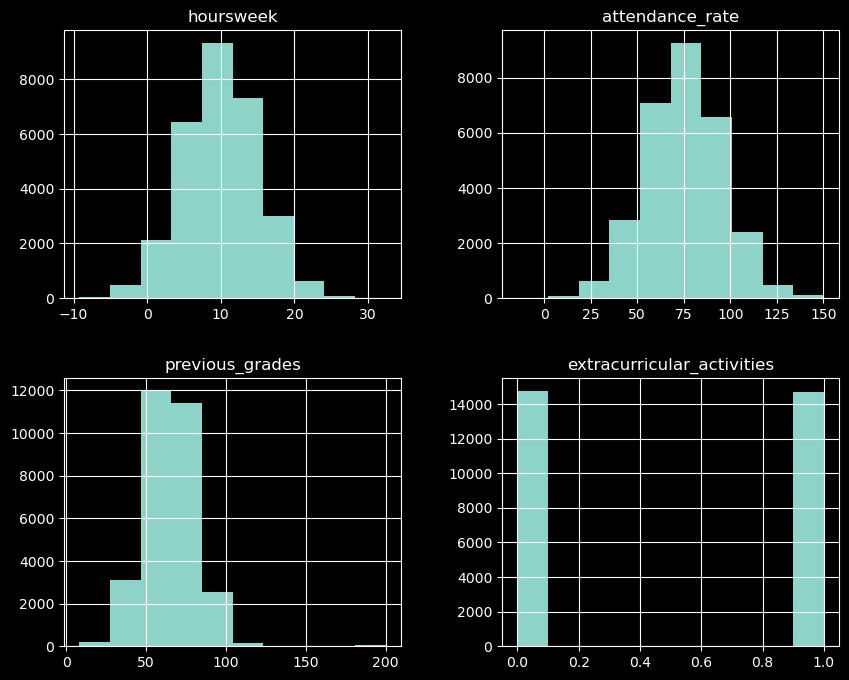

In [63]:
df_dropna[['hoursweek','attendance_rate','previous_grades','extracurricular_activities']].hist(figsize=(10, 8));

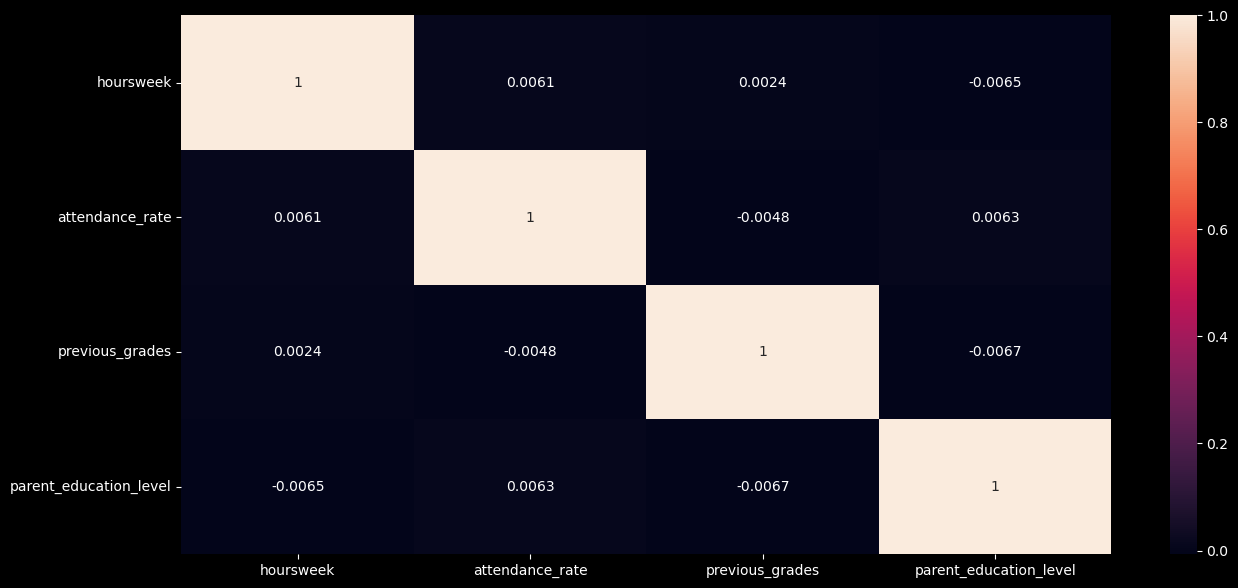

In [64]:
# создание матрицы корреляции
corr_matrix = df_dropna[['hoursweek','attendance_rate','previous_grades','parent_education_level']].corr()

# отрисовка матрицы
plt.figure(figsize=(15, 7))
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

In [85]:
# распределение по образованю родителей
df_dropna.parent_education_level.value_counts()

parent_education_level
1    5948
0    5928
2    5914
3    5907
4    5749
Name: count, dtype: int64

In [66]:
# разделение датасета на 2 части - те кто завершили обучение, и кто нет
df_0 = df_dropna[df_dropna.passed == 1]
df_1 = df_dropna[df_dropna.passed == 0]

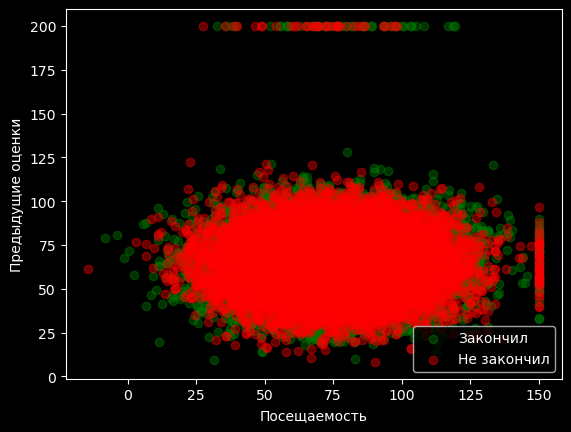

In [67]:
# визуализация зависимости оценок от посещаемости с указанием успеха окончания обучения.
plt.scatter(df_0.attendance_rate, df_0.previous_grades, color="green", label="Закончил", alpha=0.4)
plt.scatter(df_1.attendance_rate, df_1.previous_grades, color="red", label="Не закончил", alpha=0.4)
plt.xlabel(features_dict["attendance_rate"])
plt.ylabel(features_dict["previous_grades"])
plt.legend(loc='lower right')
plt.show()

In [68]:
(df_dropna.previous_grades == 200).sum()

80

In [69]:
(df_dropna.attendance_rate == 150).sum()

77

## Формирование X и Y

In [86]:
# предсказываем 0 или 1 - Закончит обучение или нет, X - все остальные признаки (задача классификации)
X = df_dropna.drop(columns='passed').values
y = df_dropna[['passed']].values

X.shape, y.shape

((29446, 5), (29446, 1))

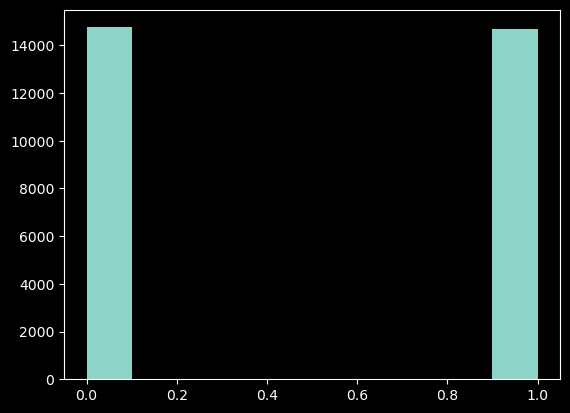

In [71]:
# распределение целевой переменной
plt.hist(y);

In [87]:
# разбиение на выборки для обучения и для тестирования модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23556, 5), (5890, 5), (23556, 1), (5890, 1))

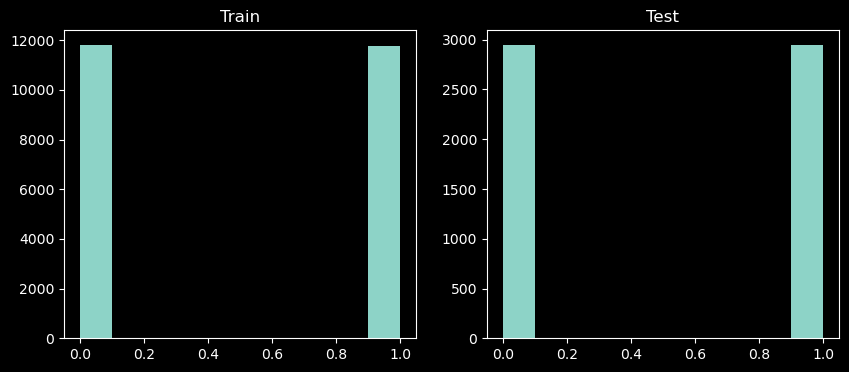

In [88]:
# посмотреть рапределение целевой переменной для y_train и y_test
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Train')
plt.hist(y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plt.hist(y_test)
plt.show()

## Обучение модели

In [89]:
# инициализация модели для решения задачи классификации
model = DecisionTreeClassifier(random_state=111)

# обучение модели
model.fit(X_train, y_train)

# метрика качества на тестовых данных accuracy (для проверки как хорошо обучилась модель)
# алгоритмы классификации выдают метрику accuracy, алгоритмы регресии - R2 score
accuracy = model.score(X_test, y_test)
accuracy

0.5052631578947369

## Инференс модели

In [90]:
# рандомные параметры для предсказания, данные которые пришли на вход
data = dict(
    hoursweek=8.8,
    attendance_rate=89.3,
    previous_rades=51.4,
    extracurricular_activities='Yes',
    parent_education_level='Bachelor'
)
# создать датафрейм для отображения в приложении
data_df = pd.DataFrame([data])
data_df

,hoursweek,attendance_rate,previous_rades,extracurricular_activities,parent_education_level
0,8.8,89.3,51.4,Yes,Bachelor


## Сериализация модели

In [91]:
import pickle

# сохранить на диск в формате pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)